# Used Cars Pricing Insights

## Contents

    . Section A: Business Understanding
    . Section B: Libraries
    . Section C: Data Understanding
    . Section D: Data Preparation
    . Section E: Modeling
    . Section F: Evaluation & Deployment

## Section A: Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Overview

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### Business Goal

Get pricing insights for used cars to determine procurement pricing and strategy, sales pricing and statrgy, and car segments to focus for maximizing revenue

### Technical Objectives from data perspective

    1. Exploratory Data Analysis for getting insights into data features, their inter-relationships and influence on pricing
    2. Data Curation to handle data discrepancies including duplicates, outliers, nulls and special issues
    3. Appropriate feature scaling techniques for numerical and categorical features
    4. Modeling and hyperparameter tuning for building Regression models that determine pricing accuracy based on features
    5. Appropriate Evaluation metrics for measuring efficiencies of model

## Section B: Libraries

### B1) Generic Libraries

In [2]:
# data structures
import pandas as pd
import numpy as np

# my folder path
from pathlib import Path
myfolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/")
BerkAIdatafolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/berkAIdata/")

# for timing program run
import time

# graphs
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

# train/test split
from sklearn.model_selection import train_test_split

# supress warning
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.exceptions import FitFailedWarning 

# code to overcome my system specific errors
# patch for overcoming 'float' error in nump 24.1v
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

# Classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# ColTransf / Pipeline / GridSearch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# evaluation libs
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

### B2) ZSRV - Sravan Katragadda custom Libraries

These are my custom defined functions I have developed my years of learning and working in AI & ML

In [3]:
# zsrv function for quick data analyis

def data_quickanalysis(df):
    print('Quick Data Analysis')
    print("Dataset shape:  ",df.shape)
    print("Dataset size:   ",df.size)
    print("# of columns with numerical features  :   ",len(df.select_dtypes(include=['int64', 'float64']).columns.values))
    print("# of columns with categorical features:   ",len(df.select_dtypes(include=['object', 'category']).columns.values))
    
    num_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_features = list(df.select_dtypes(include=['object', 'category','bool']).columns.values)
    #This is a check to see if any features are being missed out
    oth_features = list(set(df.columns.tolist()) - set(num_features) - set(cat_features))
    
    print('Numerical features:', num_features)
    print('Categorical features:', cat_features)
    print('non-num/non-cat features:', oth_features)
    print()
    
def info_df(df):
    
    # io module provides tools for working with text I/O, binary I/O, and raw I/O
    import io
    # Create a buffer to capture the output of df.info()
    buffer = io.StringIO()
    df.info(buf=buffer)
    s = buffer.getvalue()
    # Parse the captured text into a DataFrame
    info_lines = s.split('\n')
    info_data = [line.split(maxsplit=4) for line in info_lines[5:-3]]
    columns = ['#', 'column', '# of non-nulls', 'non-null', 'Data Type']
    info_df = pd.DataFrame(info_data, columns=columns)
    
    
    info_df['# of non-nulls'] = info_df['# of non-nulls'].astype('int64')
    s = df.shape[0]
    info_df['# of nulls'] = s - info_df['# of non-nulls']
    info_df['% of nulls'] = round((info_df['# of nulls'] / s * 100),1)
    
    info_df = info_df.reset_index()
    info_df.index = range(1, len(info_df) + 1)
    info_df = info_df[['column','Data Type','# of nulls','% of nulls']]
    
    return(info_df)

# zsrv function for getting null values information

def nulls_info(df):    

    # getting df with null info
    datasetsize = df.shape[0]
    df_nullinfo = pd.DataFrame(df.isna().sum(),columns=['# of Null Values'])
    df_nullinfo['% of Null Values'] = (df_nullinfo['# of Null Values'] / datasetsize * 100).round(1)
    return df_nullinfo

# --------------------------------------------------------------------------------------------------

def nulls_remove(df):
    
    pre_size = df.shape[0]
    # Removing rows with null values
    df.dropna(inplace=True)
    post_size = df.shape[0]
    print('Data loss in removing nulls:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    return df

# --------------------------------------------------------------------------------------------------

def nulls_impute(df):
    
    num_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_features = list(df.select_dtypes(include=['object', 'category','bool']).columns.values)
    print(f'There are {len(num_features)} numerical features and {len(cat_features)} categorical features in {datasetname} dataset')
    # Define imputers
    numerical_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='constant',fill_value='missing')
    # Numerical Values Imputation
    df[num_features] = numerical_imputer.fit_transform(df[num_features])
    # Categorical Values Imputation
    df[cat_features] = categorical_imputer.fit_transform(df[cat_features])
    # return df
    return df

def IQRoutliers_info(df):
    
    # get Data Loss %
    '''df1 = df
    pre_size = df1.shape[0]
    
    for col in df1.select_dtypes(include=['float64', 'int64']).columns.tolist():
        q1 = df1[col].quantile(0.25)
        q3 = df1[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df1 = df1[(df1[col] >= lower_bound) & (df1[col] <= upper_bound)]
    
    post_size = df1.shape[0]
    print('Data loss in removing nulls:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    '''
    
    # get only numerical columns
    df = df.select_dtypes(include=['number'])
    
    # getting df with outlier info
    datasetsize = df.shape[0]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_IQRoutliersinfo = pd.DataFrame(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum(),columns=['# of Outliers'])
    df_IQRoutliersinfo['% Outliers'] = (df_IQRoutliersinfo['# of Outliers'] / datasetsize * 100).round(1)
    return df_IQRoutliersinfo

def IQRoutliers_remove(df):
    
    # get Data Loss %
    pre_size = df.shape[0]
    
    for col in df.select_dtypes(include=['float64', 'int64']).columns.tolist():
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    post_size = df.shape[0]
    print('Data loss in removing IQQ outliers:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    return df

# --------------------------------------------------------------------------------------------------

# zsrv function to get highly correlated features
def get_high_correlated_features(df):
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    # Remove duplicate values and keep the upper triangle
    corr_matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Flatten the matrix and drop NA values (diagonal values)
    corrdf = corr_matrix_upper.stack().reset_index()
    corrdf.columns = ['Feature 1', 'Feature 2', 'PearsonCorrCoef']
    high_corrdf = corrdf[(corrdf['PearsonCorrCoef'] <= -0.7)]
    high_corrdf = corrdf[(corrdf['PearsonCorrCoef'] >= 0.7)]
    
    print(f'There are {len(high_corrdf)} feature combinations that are HIGHLY correlated by Pearson Correlation Coefficient')
    p = len(high_corrdf.query('PearsonCorrCoef > 0.7'))
    print(f'There are {p} feature combinations that are HIGHLY positively correlated by Pearson Correlation Coefficient')
    n = len(high_corrdf.query('PearsonCorrCoef < -0.7'))
    print(f'There are {n} feature combinations that are HIGHLY negatively correlated by Pearson Correlation Coefficient')
    
    return filt_corrdf

# --------------------------------------------------------------------------------------------------

# My custom function for Preprocessing X

def preprocessX(A):
    
    # features
    num_all_features = list(A.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_all_features = list(A.select_dtypes(include=['object', 'category','bool']).columns.values)

    # Numerical Transformation
    num_transform = Pipeline (steps=[('mms', MinMaxScaler())])

    # Categorical Operations
    cat_transform = Pipeline (steps=[('ore', OrdinalEncoder())])

    # Column Transformer (CT)
    preprocessor = ColumnTransformer(transformers=[
                    ('num_tran', num_transform, num_all_features),
                    ('cat_tran', cat_transform, cat_all_features),
                    ])
    
    B = preprocessor.fit_transform(A)
    return(B)

## Section C: Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### C1) Getting Data from source

In [4]:
rawdata = pd.read_csv(BerkAIdatafolder / 'vehicles.csv')

datasetname = 'UsedCarsPrices'

rawdata.sample(4)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
188723,7310733237,cape cod / islands,36590,2019.0,bmw,4 series 440i xdrive gran,good,NaN,gas,17647.0,clean,other,WBA4J7C51KBM74333,NaN,NaN,coupe,black,ma
220527,7315994874,joplin,21000,2005.0,jeep,wrangler rubicon unlimited,excellent,6 cylinders,gas,100433.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,mo
421915,7302262151,madison,5300,1999.0,chevrolet,camero,excellent,6 cylinders,gas,159800.0,clean,automatic,NaN,rwd,mid-size,convertible,red,wi
394770,7307330250,norfolk / hampton roads,2990,2003.0,ford,explorer,NaN,NaN,gas,240413.0,clean,automatic,1FMZU72K83UA55811,4wd,NaN,SUV,white,va


### C2) Columns curation

Here only columns will be modified and there will be no change to rows.

 1. drop irrelevant columns 
 2. column names handling
 3. columns sort

In [5]:
data = rawdata

# 1) removing obviously irrelevant columns
drop_col = ['id','model','region','VIN']
data = data.drop(drop_col, axis=1, errors='ignore')

# 2) column names handling - rename, case handling
data.columns = data.columns.str.lower()

# 3) columns sort 
y_column = ['price']
num_features = ['year', 'odometer']
cat_features = ['manufacturer',  'cylinders', 'fuel','transmission','drive',
                'condition','title_status', 'type', 'size', 'paint_color', 'state']
column_order = y_column + num_features + cat_features
data = data[column_order]

data.dropna().sample(5)

,price,year,odometer,manufacturer,cylinders,fuel,transmission,drive,condition,title_status,type,size,paint_color,state
97429,35500,2019.0,7189.0,chevrolet,8 cylinders,gas,automatic,4wd,like new,clean,truck,full-size,black,fl
93645,9995,2010.0,80156.0,toyota,4 cylinders,gas,automatic,fwd,excellent,clean,sedan,mid-size,silver,fl
339949,16700,2011.0,154000.0,chevrolet,8 cylinders,gas,automatic,rwd,excellent,clean,truck,full-size,white,pa
415818,27450,2018.0,22700.0,ford,6 cylinders,gas,automatic,4wd,like new,rebuilt,SUV,mid-size,black,wi
308459,15997,2012.0,159519.0,chevrolet,8 cylinders,gas,automatic,rwd,excellent,clean,truck,full-size,white,ok


### C3) Data Information

my custom defined function for understanding data

In [6]:
info_df(data)

,column,Data Type,# of nulls,% of nulls
1,price,int64,0,0.0
2,year,float64,1205,0.3
3,odometer,float64,4400,1.0
4,manufacturer,object,17646,4.1
5,cylinders,object,177678,41.6
6,fuel,object,3013,0.7
7,transmission,object,2556,0.6
8,drive,object,130567,30.6
9,condition,object,174104,40.8
10,title_status,object,8242,1.9


### C3) Handling Duplicates, Outliers, Nulls, Special issues

In [7]:
# Duplicates

print('Duplicate rows:',data.duplicated().sum())
print("%.2f" % (data.duplicated().sum()/len(data)*100), 'percent of rows are duplicates')

Duplicate rows: 130218
30.50 percent of rows are duplicates


In [8]:
# There are lot of duplicates after removing id, model and region.
# I am removing these

data = data.drop_duplicates()

In [9]:
print('Duplicate rows:',data.duplicated().sum())
print("%.2f" % (data.duplicated().sum()/len(data)*100), 'percent of rows are duplicates')

Duplicate rows: 0
0.00 percent of rows are duplicates


#### using my custom function modules to analyze and remove outliers

In [10]:
# Removing Outliers

print(IQRoutliers_info(data))

# Removing Outlier
data = IQRoutliers_remove(data)

print(IQRoutliers_info(data))

          # of Outliers  % Outliers
price              7310         2.5
year              12666         4.3
odometer           3336         1.1
Data loss in removing IQQ outliers: 9.01 %
          # of Outliers  % Outliers
price               790         0.3
year                832         0.3
odometer             91         0.0


In [11]:
# Nulls in Data

nulls_info(data)

,# of Null Values,% of Null Values
price,0,0.0
year,0,0.0
odometer,0,0.0
manufacturer,8473,3.1
cylinders,104796,38.8
fuel,1332,0.5
transmission,1079,0.4
drive,78875,29.2
condition,100920,37.4
title_status,4032,1.5


#### using my custom function modules to Impute

Since there are a lot of nulls, we cannot remove the null rows.

we need to impute with values

IMPUTATION STRATEGY:

    1. Numerical Features: fill with mean (no need to consider median which accounts for outliers, since they are removed)
    2. Categorical Features: fill with 'Missing' constant

In [12]:
# Imputings Nulls in Numerical and Categorical variables

print(nulls_info(data))

data = nulls_impute(data)

print(nulls_info(data))

              # of Null Values  % of Null Values
price                        0               0.0
year                         0               0.0
odometer                     0               0.0
manufacturer              8473               3.1
cylinders               104796              38.8
fuel                      1332               0.5
transmission              1079               0.4
drive                    78875              29.2
condition               100920              37.4
title_status              4032               1.5
type                     59134              21.9
size                    184708              68.4
paint_color              77000              28.5
state                        0               0.0
There are 3 numerical features and 11 categorical features in UsedCarsPrices dataset
              # of Null Values  % of Null Values
price                        0               0.0
year                         0               0.0
odometer                     0   

In [13]:
# Special Issue - data type conversion for numerical data

dtypeconvert_dict = {'year':'int64', 'odometer':'int64'}
data = data.astype(dtypeconvert_dict)

#### Data is ready for analysis

In [14]:
UsedCarPrices = data

# X/y split
y_column = ["price"]
UsedCarPrices_X  = data.drop(y_column, axis=1, errors='ignore')
UsedCarPrices_y  = data[y_column].copy()

### C4) Exploratory Data Analysis

### Numerical Features

In [15]:
# Statistics of Numerical Data

UsedCarPrices.describe()

,price,year,odometer
count,269942.000000,269942.000000,269942.000000
mean,15340.138696,2011.981066,96118.591475
std,12297.927607,5.722555,61425.056196
min,0.000000,1994.000000,0.000000
25%,5500.000000,2008.000000,43062.000000
50%,12000.000000,2013.000000,92885.000000
75%,23588.000000,2017.000000,139200.000000
max,52944.000000,2022.000000,285800.000000


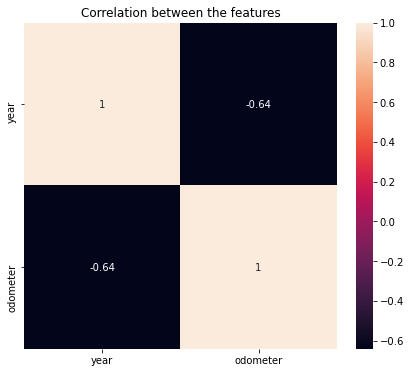

In [30]:
# Correlation between Features

plt.figure(figsize=(7,6))
sns.heatmap(UsedCarPrices_X.corr(), annot=True)
plt.title('Correlation between the features')
plt.show()

There is STRONG negative correlation between Year and Odometer, which is intuitive.

The older the year the higher the mileage

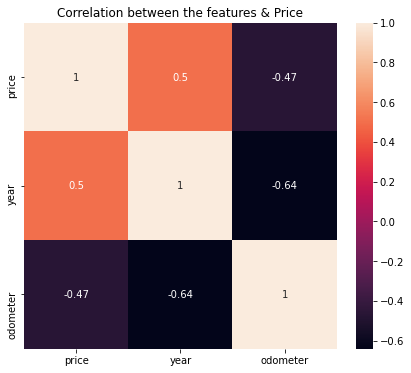

In [34]:
# Correlation between Features

plt.figure(figsize=(7,6))
sns.heatmap(UsedCarPrices.corr(), annot=True)
plt.title('Correlation between the features & Price')
plt.show()

There is WEAK positive correlation between Price and year

There is WEAK negative correlation between Price and Odometer reading

In [ ]:
# SCATTER PLOTS for numerical features & Price relationship

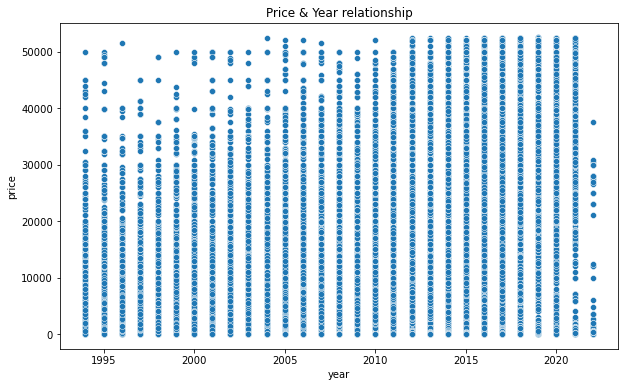

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=UsedCarPrices, x='year', y='price')
plt.title('Price & Year relationship')
plt.show()

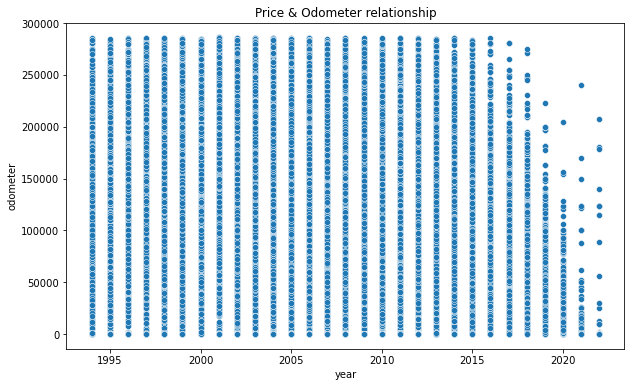

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=UsedCarPrices, x='year', y='odometer')
plt.title('Price & Odometer relationship')
plt.show()

### Categorical Variables

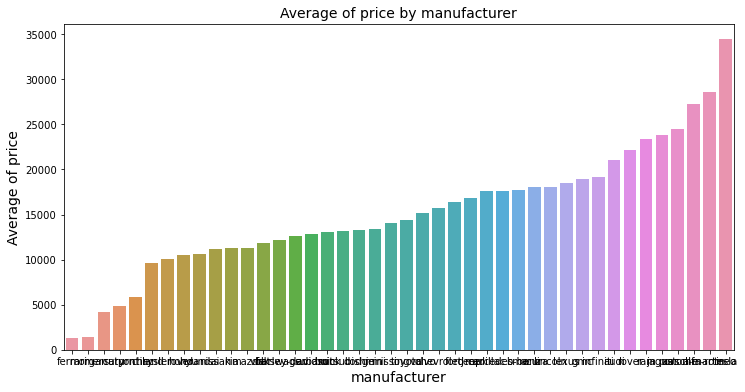

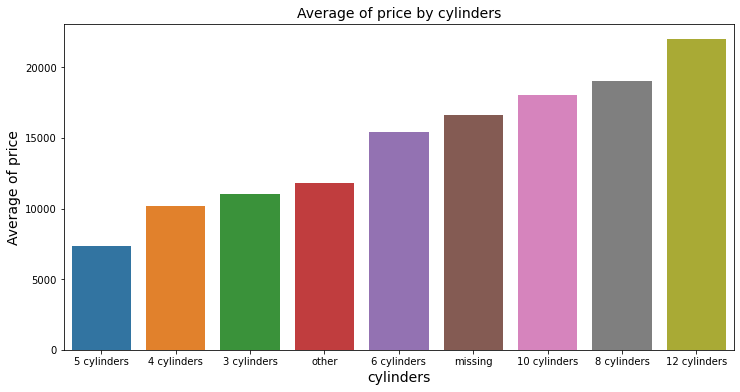

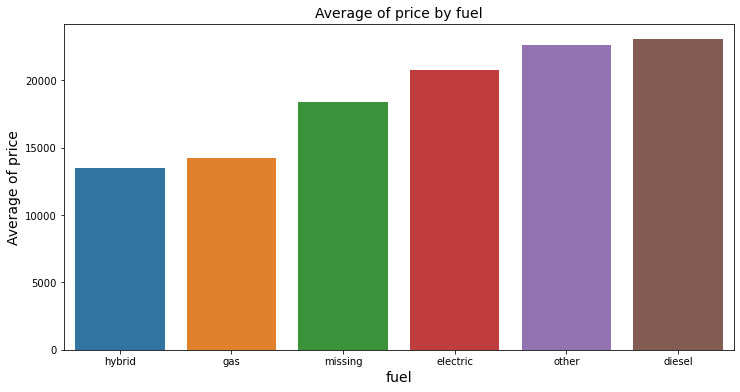

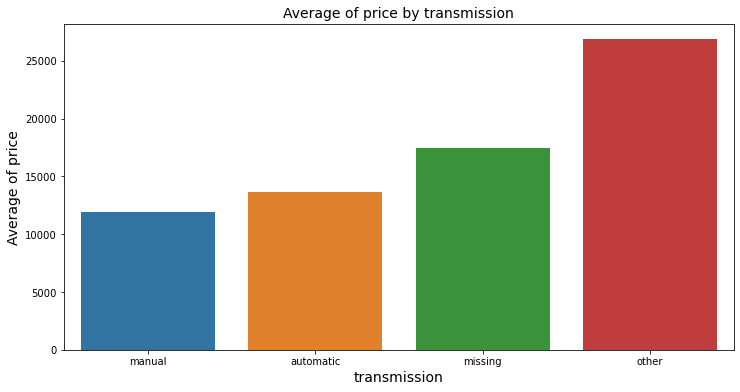

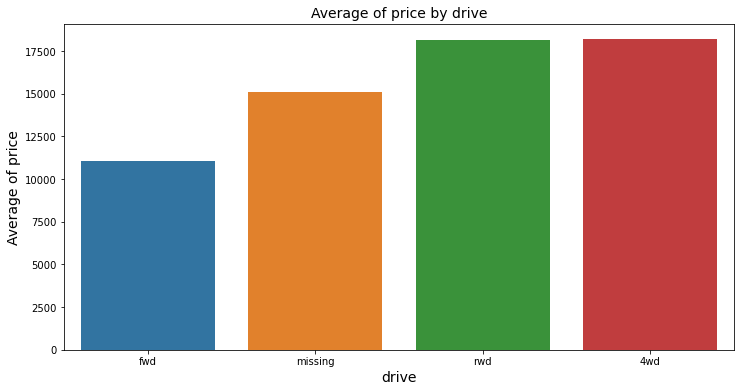

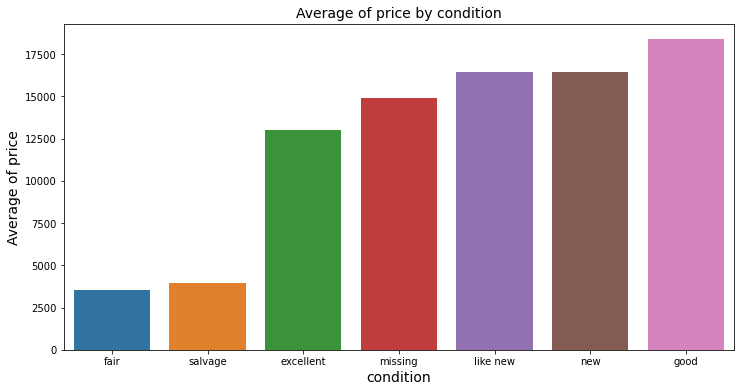

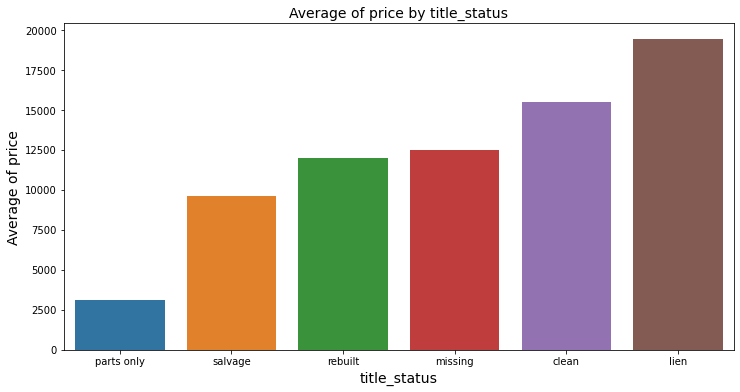

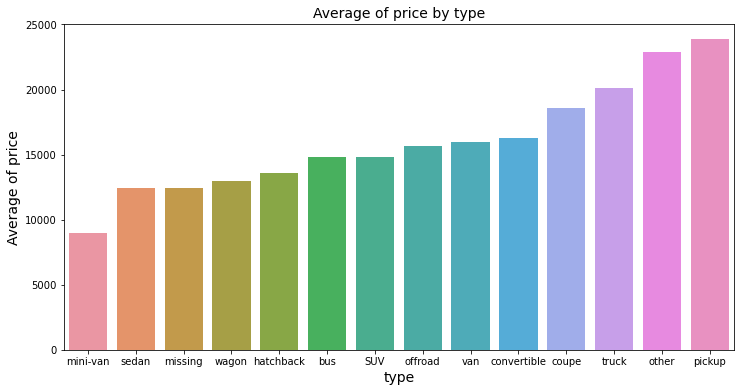

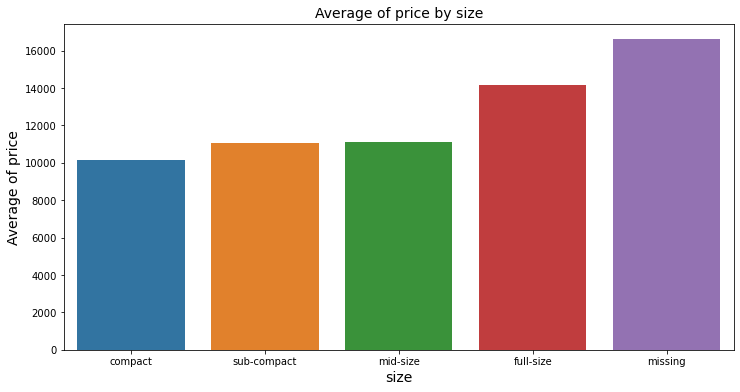

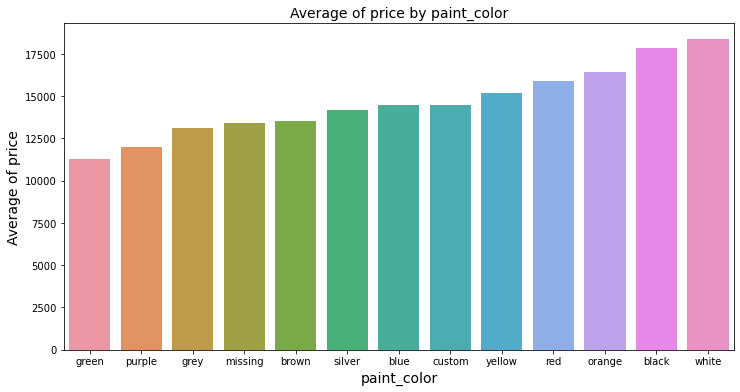

In [35]:
# Visualizing the Average Pricing by different values of the various features

df = UsedCarPrices

cols = ['manufacturer', 'cylinders', 'fuel', 'transmission', 'drive', 
        'condition', 'title_status', 'type', 'size', 'paint_color']


for col in cols:
    grouped_df = df.groupby(col)['price'].mean().reset_index()
    grouped_df = grouped_df.sort_values(by='price', ascending=True)
   
    plt.figure(figsize=(12,6))
    sns.barplot(x=col, y='price', data=grouped_df)
    # Set plot title and labels
    plt.title(f'Average of price by {col}',fontsize=14)
    plt.xlabel(col,fontsize=14)
    plt.ylabel('Average of price',fontsize=14)
    plt.show()

## Section D: Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

### D1) Feature Scaling

I use my custom function module for Feature Scaling:

1. Numerical Features: Normalized with Min Max Scaler
2. Categorical Features: Ordinal Encoded

In [16]:
# Scaling X

UsedCarPrices_X_scaled = pd.DataFrame(preprocessX(UsedCarPrices_X),columns=UsedCarPrices_X.columns.tolist())

UsedCarPrices_X_scaled.sample(5)

,year,odometer,manufacturer,cylinders,fuel,transmission,drive,condition,title_status,type,size,paint_color,state
13457,0.607143,0.728688,13.0,6.0,2.0,0.0,2.0,3.0,0.0,6.0,3.0,11.0,2.0
103570,0.857143,0.121638,19.0,7.0,2.0,0.0,2.0,4.0,0.0,6.0,3.0,6.0,12.0
191025,0.607143,0.566830,20.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,35.0
35959,0.821429,0.143093,12.0,6.0,2.0,0.0,0.0,2.0,0.0,11.0,1.0,5.0,4.0
68047,0.678571,0.567792,12.0,5.0,2.0,0.0,3.0,4.0,0.0,11.0,3.0,1.0,9.0


### D2) Train/Test Split

Splitting the X and y data into Training and Testing Sets for evaluating model accuracy

In [17]:
X_train, X_test, y_train, y_test = train_test_split(UsedCarPrices_X_scaled, UsedCarPrices_y, test_size = 0.2)

## Section E: Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Models Chosen:

    1. Linear Regression
    2. Lasso Regression
    3. Ridge Regression
    4. Random Forest Regression

### E1) Linear Regression

In [18]:
model_lin = LinearRegression()
model_lin.fit(X_train,y_train)

y_pred = model_lin.predict(X_test)

print('Linear Regression Score')
print("Training Accuracy:", "%.4f" % model_lin.score(X_train, y_train))
print("Test Accuracy    :", "%.4f" % model_lin.score(X_test, y_test))
print("RMSE             :", "%.4f" %np.sqrt(mean_squared_error(y_test,y_pred)))

<IPython.core.display.Javascript object>

Linear Regression Score
Training Accuracy: 0.3584
Test Accuracy    : 0.3564
RMSE             : 9849.2413


In [19]:
model_lin.coef_

array([[ 2.01647973e+04, -1.15337327e+04, -3.05071060e+01,
         1.14081124e+03, -1.66473573e+03,  2.38950867e+03,
        -7.62489127e+02, -1.95328648e+02, -7.34966135e+02,
         6.71379952e+01, -9.62673118e+01,  6.32071068e+01,
        -1.07883880e+01]])

In [20]:
coefficients = [2.02340635e+04, -1.14721348e+04, -3.04842530e+01,
         1.14849085e+03, -1.66579956e+03,  2.36093783e+03,
        -7.70174333e+02, -1.90911291e+02, -7.39298265e+02,
         6.93550801e+01, -1.10994146e+02,  6.08004608e+01,
        -1.22798455e+01]

featimp_lin = pd.DataFrame({'features': UsedCarPrices_X.columns, 'LinCoeffs': coefficients})
featimp_lin

,features,LinCoeffs
0,year,20234.063500
1,odometer,-11472.134800
2,manufacturer,-30.484253
3,cylinders,1148.490850
4,fuel,-1665.799560
5,transmission,2360.937830
6,drive,-770.174333
7,condition,-190.911291
8,title_status,-739.298265
9,type,69.355080


### E2) Lasso Regression

In [21]:
model_las = Lasso(alpha=100)
model_las.fit(X_train,y_train)

y_pred = model_las.predict(X_test)

print('Linear Regression Score')
print("Training Accuracy:", "%.4f" % model_las.score(X_train, y_train))
print("Test Accuracy    :", "%.4f" % model_las.score(X_test, y_test))
print("RMSE             :", "%.4f" %np.sqrt(mean_squared_error(y_test,y_pred)))

<IPython.core.display.Javascript object>

Linear Regression Score
Training Accuracy: 0.3558
Test Accuracy    : 0.3536
RMSE             : 9870.2983


### E3) Ridge Regression

In [22]:
model_rid = Ridge(alpha=100)
model_rid.fit(X_train,y_train)

y_pred = model_rid.predict(X_test)

print('Ridge Regression Score')
print("Training Accuracy:", "%.4f" % model_rid.score(X_train, y_train))
print("Test Accuracy    :", "%.4f" % model_rid.score(X_test, y_test))
print("RMSE             :", "%.4f" %np.sqrt(mean_squared_error(y_test,y_pred)))

<IPython.core.display.Javascript object>

Ridge Regression Score
Training Accuracy: 0.3584
Test Accuracy    : 0.3563
RMSE             : 9849.5162


### E4) Random Forest Regression

In [23]:
model_ran = RandomForestRegressor()
model_ran.fit(X_train,y_train)

y_pred = model_ran.predict(X_test)

print('Random Regression Score')
print("Training Accuracy:", "%.4f" % model_ran.score(X_train, y_train))
print("Test Accuracy    :", "%.4f" % model_ran.score(X_test, y_test))
print("RMSE             :", "%.4f" %np.sqrt(mean_squared_error(y_test,y_pred)))

<IPython.core.display.Javascript object>

Random Regression Score
Training Accuracy: 0.9563
Test Accuracy    : 0.7111
RMSE             : 6598.4522


In [24]:
featimp_ran = pd.DataFrame({'features': UsedCarPrices_X.columns, 'FeatImp': model_ran.feature_importances_})
featimp_ran

,features,FeatImp
0,year,0.309052
1,odometer,0.169745
2,manufacturer,0.073558
3,cylinders,0.062762
4,fuel,0.053717
5,transmission,0.049671
6,drive,0.068002
7,condition,0.034750
8,title_status,0.007074
9,type,0.042383


### E5) Grid Search for Best Hyperparameters

In [30]:
param_grid = {
    'Linear Regression': {'fit_intercept': [True,False]},
    'Lasso': {'alpha': [0.1,1,10,100]},
    'Ridge': {'alpha': [0.1,1,10,100]}}

models = {'Linear Regression': LinearRegression(),'Lasso': Lasso(), 'Ridge':Ridge()}

best_models = {}
best_params = {}
timetaken_gridsearch = []

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
tik1 = time.time()

for name, model in models.items():
    
    tik = time.time()
    
    grid = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    
    tok = time.time()
    print('Time to run the GridSearch for' , name , 'is:' , '%.2f' % (tok-tik) , 'seconds')
    timetaken_gridsearch.append('%.1f' % (tok-tik))

tok1 = time.time()
print('Time to run the GridSearch evaluation for multiple models:' , '%.2f' % (tok1-tik1) , 'seconds')

Time to run the GridSearch for Linear Regression is: 0.94 seconds
Time to run the GridSearch for Lasso is: 1.94 seconds
Time to run the GridSearch for Ridge is: 1.22 seconds
Time to run the GridSearch evaluation for multiple models: 4.10 seconds


In [32]:
best_models

{'Linear Regression': LinearRegression(),
 'Lasso': Lasso(alpha=0.1),
 'Ridge': Ridge(alpha=0.1)}

## Section F: Evaluation & Deployment

**Evaluation:** With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

**Deployment:** Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### F1) Final Model Scores

In [51]:
# Running Evaluation metrics for best parameters of all 4 models

names  = ['Linear Regression', 'Lasso', 'Ridge']

RMSE = []
acc_train = []
acc_test  = []

In [52]:
for name, model in best_models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    RMSE.append("%.4f" % np.sqrt(mean_squared_error(y_test,y_pred)))
    acc_train.append("%.4f" %model.score(X_train, y_train))
    acc_test.append("%.4f" %model.score(X_test, y_test))
    
Df = pd.DataFrame({'RMSE':RMSE,'Train Accuracy':acc_train,'Test Accuracy':acc_test})
Df = Df.T
Df.columns = names
evaluation_final = Df.apply(pd.to_numeric, errors='coerce')
evaluation_final

,Linear Regression,Lasso,Ridge
RMSE,9849.2413,9849.2428,9849.2414
Train Accuracy,0.3584,0.3584,0.3584
Test Accuracy,0.3564,0.3564,0.3564


In [57]:
# Appending Values of Random Forest

evaluation_final['Random'] = [6598.4522,0.9563,0.7111]
evaluation_final.apply(pd.to_numeric, errors='coerce')

,Linear Regression,Lasso,Ridge,Random
RMSE,9849.2413,9849.2428,9849.2414,6598.4522
Train Accuracy,0.3584,0.3584,0.3584,0.9563
Test Accuracy,0.3564,0.3564,0.3564,0.7111


In [65]:
evaluation_final = evaluation_final.T

evaluation_final

,RMSE,Train Accuracy,Test Accuracy
Linear Regression,9849.2413,0.3584,0.3564
Lasso,9849.2428,0.3584,0.3564
Ridge,9849.2414,0.3584,0.3564
Random,6598.4522,0.9563,0.7111


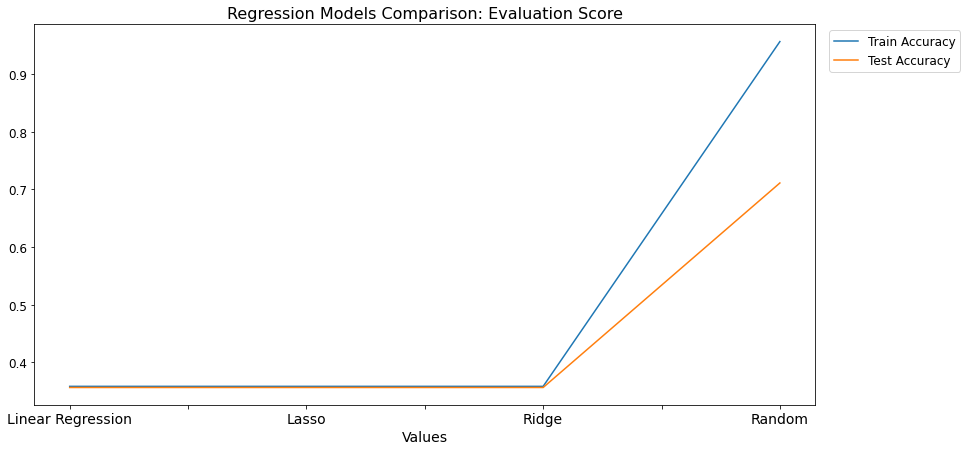

In [72]:
evaluation_final.drop(columns=['RMSE']).plot(kind='line',figsize=(14, 7))
plt.title('Regression Models Comparison: Evaluation Score', fontsize=16)
plt.xlabel('Models', fontsize=14);plt.xlabel('Values', fontsize=14);
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',fontsize=12);
plt.xticks(fontsize=14); plt.yticks(fontsize=12);plt.show()

### F2) Feature Importance

In [69]:
# Feature Importance By Random Forest

featimp_ran

,features,FeatImp
0,year,0.309052
1,odometer,0.169745
2,manufacturer,0.073558
3,cylinders,0.062762
4,fuel,0.053717
5,transmission,0.049671
6,drive,0.068002
7,condition,0.034750
8,title_status,0.007074
9,type,0.042383


In [71]:
# Feature Importance By Linear Regression

featimp_lin.sort_values(by='LinCoeffs',ascending=False)

,features,LinCoeffs
0,year,20234.063500
5,transmission,2360.937830
3,cylinders,1148.490850
9,type,69.355080
11,paint_color,60.800461
12,state,-12.279846
2,manufacturer,-30.484253
10,size,-110.994146
7,condition,-190.911291
8,title_status,-739.298265


### F3) Report and Insights

    1. The dataset was evaluated with 4 models Linear Regression, Lasso Regression, Ridge Regression and Random Forest.
    2. Random Forest was the best performing model among all 4 models
    3. Linear Regression, Lasso and Ridge performed very poorly for this dataset even with hyperparameter tuning
    4. Random Forest modeling took significant computational resource and was time consuming. Finetuning for Random Forest had to be interupted because it was taking too long
    5. There is STRONG negative correlation between Year and Odometer, which is intuitive. The older the year the higher the mileage
    6. There is WEAK positive correlation between Price and year
    7. There is WEAK negative correlation between Price and Odometer reading
    8. Based on Random Forest feature importance Year, Odometer, Manufacturer and Cylinder turned out to be the most significant features
    9. The client is asked to present any further data associated with the used cars that might be helpful in better modeling


### F4) Future Work

    1. The poor accuracy shows the need to improve the features by feature engineering
    2. This effort will be taken up in my Capstone Project